In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import ast
from collections import defaultdict
import re
from datetime import datetime
import time
from tqdm import tqdm
from collections import defaultdict, Counter
import numpy as np



# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans

# NLP
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from textblob import TextBlob
from textblob import TextBlob



# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Time Series
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [19]:
from google.colab import userdata
rapid_api_key = userdata.get("RAPID_API_KEY")

In [3]:
import requests

In [20]:
tiktok_creative_center_api_headers = {
    "X-RapidAPI-Key": rapid_api_key,
    "X-RapidAPI-Host": "tiktok-creative-center-api.p.rapidapi.com"
}

In [21]:
def fetch_trending_creators(page, limit, sort_by, country, audience_count, audience_country):
    url = "https://tiktok-creative-center-api.p.rapidapi.com/api/trending/creator"
    querystring = {"page":str(page),"limit":str(limit),"sort_by":sort_by,"country":country,"audience_count":str(audience_count),"audience_country":str(audience_country)}

    response = requests.get(url, headers=tiktok_creative_center_api_headers, params=querystring)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

#user input
page = 1
limit = 40
sort_by = "follower"
# values: "follower", "engagement", "avg_views"
# avg_views: Popularity
country = ""
audience_count = 1
# 1: 10k->100k
# 2: 100k -> 1m
# 3: 1m -> 10m
# 4: >10m
audience_country = ""

raw_trending_creators = fetch_trending_creators(page, limit, sort_by, country, audience_count, audience_country)
print(raw_trending_creators)

{'code': 0, 'msg': 'OK', 'request_id': '2025090616093421FED7EFB2BFD4DA126E', 'data': {'creators': [{'tcm_id': '7414477993612935173', 'user_id': '62133858422239232', 'nick_name': 'Fernanda', 'avatar_url': 'https://p16-sign-va.tiktokcdn.com/tos-maliva-avt-0068/200b649d30f76f1238d771f4aff51ee1~tplv-tiktokx-cropcenter:100:100.png?dr=14579&refresh_token=8dd865a5&x-expires=1757318400&x-signature=EUez7Q%2BK1ukTflthVvS8AooJBuA%3D&t=4d5b0474&ps=13740610&shp=a5d48078&shcp=317596d8&idc=my', 'country_code': 'US', 'follower_cnt': 9135515, 'liked_cnt': 668294555, 'tt_link': 'https://www.tiktok.com/@ferchugimenez', 'tcm_link': 'https://creatormarketplace.tiktok.com/ad#/author/7414477993612935173', 'items': [{'item_id': '7444674312784645432', 'cover_url': 'https://p16-sign-va.tiktokcdn.com/tos-maliva-p-0068/oQIBhn2EeBMUWQR5wVQACFEBtlDxgUDdAfoB8J~tplv-noop.image?t=9276707c&x-expires=1757167844&x-signature=4z119HBEwCq30UObOu%2BtXIEklZk%3D', 'tt_link': 'https://www.tiktok.com/@author/video/74446743127846

In [22]:
def parse_trending_creators(raw_trending_creators):
    creators = []

    for creator in raw_trending_creators.get("data", {}).get("creators", []):
      try:

        creator_data = {
            "user_id": creator.get("user_id", ""),
            "nick_name": creator.get("nick_name", ""),
            "avatar_url": creator.get("avatar_url", ""),
            "country_code": creator.get("country_code", ""),
            "follower_cnt": creator.get("follower_cnt", None),
            "liked_cnt": creator.get("liked_cnt", None),
            "tt_link": creator.get("tt_link", ""),
            "tcm_link": creator.get("tcm_link", ""), # tiktok creator market
        }

        creators.append(creator_data)
      except Exception as e:
          print(f"Error parsing post: {e}")
    return creators

parsed_trending_creators = parse_trending_creators(raw_trending_creators)
parsed_trending_creators

[{'user_id': '62133858422239232',
  'nick_name': 'Fernanda',
  'avatar_url': 'https://p16-sign-va.tiktokcdn.com/tos-maliva-avt-0068/200b649d30f76f1238d771f4aff51ee1~tplv-tiktokx-cropcenter:100:100.png?dr=14579&refresh_token=8dd865a5&x-expires=1757318400&x-signature=EUez7Q%2BK1ukTflthVvS8AooJBuA%3D&t=4d5b0474&ps=13740610&shp=a5d48078&shcp=317596d8&idc=my',
  'country_code': 'US',
  'follower_cnt': 9135515,
  'liked_cnt': 668294555,
  'tt_link': 'https://www.tiktok.com/@ferchugimenez',
  'tcm_link': 'https://creatormarketplace.tiktok.com/ad#/author/7414477993612935173'},
 {'user_id': '21010142',
  'nick_name': 'Calle y Poché',
  'avatar_url': 'https://p16-sign-va.tiktokcdn.com/tos-maliva-avt-0068/e7cafbb4ddb12d6a1f32e93d0819c6b6~tplv-tiktokx-cropcenter:100:100.png?dr=14579&refresh_token=604ae1d2&x-expires=1757318400&x-signature=lhNP8%2F1CCq2rWvViAgXNjnvtD1k%3D&t=4d5b0474&ps=13740610&shp=a5d48078&shcp=317596d8&idc=my',
  'country_code': 'US',
  'follower_cnt': 6008392,
  'liked_cnt': 1448

In [23]:
trending_creators_df = pd.DataFrame(parsed_trending_creators)
trending_creators_df

,user_id,nick_name,avatar_url,country_code,follower_cnt,liked_cnt,tt_link,tcm_link
0,62133858422239232,Fernanda,https://p16-sign-va.tiktokcdn.com/tos-maliva-a...,US,9135515,668294555,https://www.tiktok.com/@ferchugimenez,https://creatormarketplace.tiktok.com/ad#/auth...
1,21010142,Calle y Poché,https://p16-sign-va.tiktokcdn.com/tos-maliva-a...,US,6008392,144816106,https://www.tiktok.com/@calleypoche,https://creatormarketplace.tiktok.com/ad#/auth...
2,319473670752616448,Leidyy🌺,https://p16-sign-va.tiktokcdn.com/tos-maliva-a...,US,5411150,290599457,https://www.tiktok.com/@ladyriascos,https://creatormarketplace.tiktok.com/ad#/auth...
3,6799141435654341638,Valery Urdaneta,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,US,5139042,115636031,https://www.tiktok.com/@valery.urda,https://creatormarketplace.tiktok.com/ad#/auth...
4,18671956,luann diez,https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...,US,4279653,217498429,https://www.tiktok.com/@luanndiez,https://creatormarketplace.tiktok.com/ad#/auth...
5,169368844694593537,Stefany D’Arezzo,https://p16-sign-va.tiktokcdn.com/tos-maliva-a...,US,4233995,133016293,https://www.tiktok.com/@stefanydarezzo,https://creatormarketplace.tiktok.com/ad#/auth...
6,6655269651494420485,naty,https://p16-sign-va.tiktokcdn.com/tos-maliva-a...,US,4099052,132944018,https://www.tiktok.com/@naty_sukha,https://creatormarketplace.tiktok.com/ad#/auth...
7,6715963038816470022,sarahmjeffery,https://p16-sign-va.tiktokcdn.com/tos-maliva-a...,US,3259415,38369915,https://www.tiktok.com/@sarahmariejeffery,https://creatormarketplace.tiktok.com/ad#/auth...
8,6684747467718820870,Josh Zilberberg,https://p16-sign-va.tiktokcdn.com/tos-maliva-a...,US,3048368,130131619,https://www.tiktok.com/@josh.zilberberg,https://creatormarketplace.tiktok.com/ad#/auth...
9,124059869829107712,⚡️KAREN MUNOZ ⚡️,https://p16-sign-va.tiktokcdn.com/tos-maliva-a...,US,2836386,80479991,https://www.tiktok.com/@kimmunoz2,https://creatormarketplace.tiktok.com/ad#/auth...


In [24]:
trending_creators_df.to_csv('trending_creators.csv', index=False)


In [ ]:
def fetch_trending_songs(page, limit, period, rank_type, country):
    url = "https://tiktok-creative-center-api.p.rapidapi.com/api/trending/song"
    querystring = {"page":str(page),"limit":str(limit),"period":str(period),"rank_type":rank_type,"country":country}

    response = requests.get(url, headers=tiktok_creative_center_api_headers, params=querystring)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

#user input
page = 1
limit = 20
period = 120 #values: "7", "30", "120"
rank_type = "popular" #values: "popular" or "surging"
country = ""

raw_trending_songs = fetch_trending_songs(page, limit, period, rank_type, country)
print(raw_trending_songs)

{'code': 0, 'msg': 'OK', 'request_id': '20250905164030C3A1F9A3B7ABF9B7C1B1', 'data': {'pagination': {'page': 1, 'size': 20, 'total': 100, 'has_more': True}, 'sound_list': [{'author': 'BunnaB', 'clip_id': '7492171577455593473', 'country_code': 'US', 'cover': 'https://p16-sg.tiktokcdn.com/aweme/720x720/tos-alisg-v-2774/okKnBB7nNoAYwiE0CQivAAwhzvKAeqELsABwWd.jpeg', 'duration': 60, 'if_cml': False, 'is_search': False, 'link': 'https://www.tiktok.com/music/x-7492171577455593473', 'on_list_times': None, 'promoted': False, 'rank': 1, 'rank_diff': 0, 'rank_diff_type': 2, 'related_items': [{'item_id': 7502540069014752000, 'cover_uri': 'https://p16-sign-va.tiktokcdn.com/tos-maliva-p-0068c799-us/oAIICIGuLLudPYe5PjvqACjIHOdIQqFeAQMfqI~tplv-noop.image?t=9276707c&x-expires=1757083296&x-signature=VvKQ%2F3dexWYLshOVX0Hg2G7ufo4%3D'}, {'item_id': 7522678958387662000, 'cover_uri': 'https://p16-sign-va.tiktokcdn.com/tos-maliva-p-0068c799-us/oIrwI4UJGiGb7QlUUXaDP8MsxGECBi6ILrgBA~tplv-noop.image?t=9276707c&

In [ ]:
def parse_trending_songs(raw_trending_songs):
    songs = []

    for song in raw_trending_songs.get("data", {}).get("sound_list", []):
      try:
        # Parse trend (dictionary)
        trend = []
        for t in song.get("trend", []):
            time = t.get("time")
            value = t.get("value")
            trend.append({"date": time, "value": value})

        song_data = {
            "author": song.get("author", ""),
            "clipID": song.get("clip_id", ""),
            "country_code": song.get("country_code", ""),
            "duration": song.get("duration", ""),
            "link": song.get("link", ""),
            "promoted": song.get("promoted", False),
            "rank": song.get("rank", None),
            "songID": song.get("song_id", ""),
            "title": song.get("title", ""),
            "trend": trend,
            "urlTitle": song.get("url_title", ""),
        }

        songs.append(song_data)
      except Exception as e:
          print(f"Error parsing post: {e}")
    return songs

parsed_trending_songs = parse_trending_songs(raw_trending_songs)
parsed_trending_songs

[{'author': 'BunnaB',
  'clipID': '7492171577455593473',
  'country_code': 'US',
  'duration': 60,
  'link': 'https://www.tiktok.com/music/x-7492171577455593473',
  'promoted': False,
  'rank': 1,
  'songID': '7492170448249899009',
  'title': 'Bunna Summa',
  'trend': [{'date': 1748044800, 'value': 0.78},
   {'date': 1748649600, 'value': 1},
   {'date': 1749254400, 'value': 0.89},
   {'date': 1749859200, 'value': 0.74},
   {'date': 1750464000, 'value': 0.48},
   {'date': 1751068800, 'value': 0.41},
   {'date': 1751673600, 'value': 0.31},
   {'date': 1752278400, 'value': 0.31},
   {'date': 1752883200, 'value': 0.22},
   {'date': 1753488000, 'value': 0.14},
   {'date': 1754092800, 'value': 0.09},
   {'date': 1754697600, 'value': 0.06},
   {'date': 1755302400, 'value': 0.04},
   {'date': 1755907200, 'value': 0.04},
   {'date': 1756512000, 'value': 0.03}],
  'urlTitle': 'Bunna-Summa'},
 {'author': 'Sok Baraby',
  'clipID': '7446723477296515088',
  'country_code': 'US',
  'duration': 60,
  

In [ ]:
trending_songs_df = pd.DataFrame(parsed_trending_songs)
trending_songs_df

,author,clipID,country_code,duration,link,promoted,rank,songID,title,trend,urlTitle
0,BunnaB,7492171577455593473,US,60,https://www.tiktok.com/music/x-749217157745559...,False,1,7492170448249899009,Bunna Summa,"[{'date': 1748044800, 'value': 0.78}, {'date':...",Bunna-Summa
1,Sok Baraby,7446723477296515088,US,60,https://www.tiktok.com/music/x-744672347729651...,False,2,7446724137378416641,NO AUDIO,"[{'date': 1748044800, 'value': 0}, {'date': 17...",NO-AUDIO
2,Tollan Kim,7072513628145977346,US,60,https://www.tiktok.com/music/x-707251362814597...,False,3,7072513627990804481,Aesthetic,"[{'date': 1748044800, 'value': 1}, {'date': 17...",Aesthetic
3,Jorjiana,7502098545378429742,US,25,https://www.tiktok.com/music/x-750209854537842...,False,4,7503634006380267536,Shark (feat. Rio Da Yung Og),"[{'date': 1749254400, 'value': 0.4}, {'date': ...",Shark-feat-Rio-Da-Yung-Og
4,MOLIY & Skillibeng & Shenseea,7468711641658525713,US,60,https://www.tiktok.com/music/x-746871164165852...,False,5,7468715280215148545,Shake It To The Max (FLY) (Remix),"[{'date': 1748044800, 'value': 0.38}, {'date':...",Shake-It-To-The-Max-FLY-Remix
5,PinkPantheress,7502057134566525713,US,13,https://www.tiktok.com/music/x-750205713456652...,False,6,7499501701586651153,Illegal,"[{'date': 1748044800, 'value': 0}, {'date': 17...",Illegal
6,CYRIL & MOONLGHT & The La's,7424014547218565904,US,22,https://www.tiktok.com/music/x-742401454721856...,False,7,7503950818010335233,There She Goes,"[{'date': 1748044800, 'value': 0.03}, {'date':...",There-She-Goes
7,Lyrebirds music,6974451099088455681,US,215,https://www.tiktok.com/music/x-697445109908845...,False,8,6974451099000375297,Classic classical gymnopedie solo piano(1034554),"[{'date': 1748044800, 'value': 0.47}, {'date':...",Classic-classical-gymnopedie-solo-piano-1034554
8,AntonioVivald,7498488534715336720,US,60,https://www.tiktok.com/music/x-749848853471533...,False,9,7498494199643310081,Almost forgot that this was the whole point - ...,"[{'date': 1748044800, 'value': 0}, {'date': 17...",Almost-forgot-that-this-was-the-whole-point-Ta...
9,ivri,7509620229598971905,US,15,https://www.tiktok.com/music/x-750962022959897...,False,10,7509619317970552833,tower of memories,"[{'date': 1749859200, 'value': 0}, {'date': 17...",tower-of-memories


In [ ]:
trending_songs_df.to_csv("trending_songs.csv", index=False)
# trending_songs_df = pd.read_csv("trending_songs.csv")
# trending_songs_df

In [ ]:
def fetch_trending_keywords(page, limit, period, country, order_by, industry, objective, keyword_type):
    url = "https://tiktok-creative-center-api.p.rapidapi.com/api/trending/keyword"
    querystring = {"page":str(page),"limit":str(limit),"period":str(period),"country":country, "industry":industry, "objective":objective, "keyword_type":keyword_type}

    response = requests.get(url, headers=tiktok_creative_center_api_headers, params=querystring)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

#user input
page = 1
limit =50
period = 7 #values: "7", "30", "120"
rank_type = "popular" #values: "popular" or "surging"
country = ""
order_by = "" # allowed values not specified in documentation
industry = "" # allowed values refer here: https://gist.githubusercontent.com/apiboxguru/d36908ea2bbe307e81bcc09ccf59616b/raw/302b5a442df9a6efced1dc430fd64d10a8226aeb/tiktok-ads-industry-code.json
objective = ""
# Enum: 1: Traffic | 2: App Installs | 3: Conversions | 4: Video Views | 5: Reach | 8: Lead Generation | 14: Product Sales
# You can combine multiple objectives by using a comma. For example: 1,2
keyword_type = ""
# Enum: 1: Selling points | 2: Pain points | 3: Target audience | 4: Call-to-action | 5: Other | 6: Products
# You can combine multiple types by using a comma. For example: 1,2

raw_trending_keywords = fetch_trending_keywords(page, limit, period, country, order_by, industry, objective, keyword_type)
print(raw_trending_keywords)

{'code': 0, 'msg': 'OK', 'request_id': '20250905164152EE0698B32A78E2B5F5FB', 'data': {'keyword_list': [{'comment': 1274, 'cost': 228000, 'cpa': 16.4, 'ctr': 1.2, 'cvr': 7.76, 'impression': 32100000, 'keyword': 'free shipping', 'like': 113926, 'play_six_rate': 7.73, 'post': 8280, 'post_change': 78.76, 'share': 1330, 'video_list': ['7425681746982718737', '7443977902942719233', '7541653008204008721', '7387096339684936976', '7509010920744471838']}, {'comment': 860, 'cost': 200000, 'cpa': 9.05, 'ctr': 0.78, 'cvr': 16.35, 'impression': 37800000, 'keyword': 'summer', 'like': 58655, 'play_six_rate': 5.54, 'post': 6160, 'post_change': 65.27, 'share': 676, 'video_list': ['7532643052872158471', '7516570469210852616', '7506915640792403216', '7533575998781017375', '7532210353808231702']}, {'comment': 194, 'cost': 51100, 'cpa': 16.7, 'ctr': 0.92, 'cvr': 7.03, 'impression': 10500000, 'keyword': 'shoe', 'like': 23423, 'play_six_rate': 5.08, 'post': 4910, 'post_change': 73.64, 'share': 271, 'video_list

In [ ]:
def parse_trending_keywords(raw_trending_keywords):
    keywords = []

    for keyword in raw_trending_keywords.get("data", {}).get("keyword_list", []):
      try:
        keyword_data = {
            "comment": keyword.get("comment", None),
            "cost": keyword.get("cost", None), # Total cost (likely in cents or ad units) spent on promoting content with this keyword
            "cpa": keyword.get("cpa", None), # Cost Per Action (e.g., per click, signup, conversion).
            "ctr": keyword.get("ctr", None), # Click-Through Rate
            "cvr": keyword.get("cvr", None), # Conversion Rate
            "impression": keyword.get("impression", None),
            "keyword": keyword.get("keyword", ""),
            "like": keyword.get("like", None),
            "play_six_rate": keyword.get("play_six_rate", None), # "6-second play rate" — the percentage of people who watched at least 6 seconds of a video after it started playing
            "post_change": keyword.get("post_change", None),  # "Change in number of posts" — an increase or decrease in content volume using that keyword
            "share": keyword.get("share", None),
            "video_list": keyword.get("video_list", {}),
        }

        keywords.append(keyword_data)
      except Exception as e:
          print(f"Error parsing post: {e}")
    return keywords

parsed_trending_keywords = parse_trending_keywords(raw_trending_keywords)
parsed_trending_keywords

[{'comment': 1274,
  'cost': 228000,
  'cpa': 16.4,
  'ctr': 1.2,
  'cvr': 7.76,
  'impression': 32100000,
  'keyword': 'free shipping',
  'like': 113926,
  'play_six_rate': 7.73,
  'post_change': 78.76,
  'share': 1330,
  'video_list': ['7425681746982718737',
   '7443977902942719233',
   '7541653008204008721',
   '7387096339684936976',
   '7509010920744471838']},
 {'comment': 860,
  'cost': 200000,
  'cpa': 9.05,
  'ctr': 0.78,
  'cvr': 16.35,
  'impression': 37800000,
  'keyword': 'summer',
  'like': 58655,
  'play_six_rate': 5.54,
  'post_change': 65.27,
  'share': 676,
  'video_list': ['7532643052872158471',
   '7516570469210852616',
   '7506915640792403216',
   '7533575998781017375',
   '7532210353808231702']},
 {'comment': 194,
  'cost': 51100,
  'cpa': 16.7,
  'ctr': 0.92,
  'cvr': 7.03,
  'impression': 10500000,
  'keyword': 'shoe',
  'like': 23423,
  'play_six_rate': 5.08,
  'post_change': 73.64,
  'share': 271,
  'video_list': ['7538873437767355703',
   '7530621649758997778',

In [ ]:
trending_keywords_df = pd.DataFrame(parsed_trending_keywords)
trending_keywords_df

,comment,cost,cpa,ctr,cvr,impression,keyword,like,play_six_rate,post_change,share,video_list
0,1274,228000,16.40,1.20,7.76,32100000,free shipping,113926,7.73,78.76,1330,"[7425681746982718737, 7443977902942719233, 754..."
1,860,200000,9.05,0.78,16.35,37800000,summer,58655,5.54,65.27,676,"[7532643052872158471, 7516570469210852616, 750..."
2,194,51100,16.70,0.92,7.03,10500000,shoe,23423,5.08,73.64,271,"[7538873437767355703, 7530621649758997778, 753..."
3,173,44200,21.30,1.01,5.30,8600000,shoes,21788,5.33,72.04,239,"[7538873437767355703, 7538885722401508622, 753..."
4,482,73400,26.40,0.85,4.85,15300000,men,12289,4.48,77.66,798,"[7516665321319664913, 7483178914186104065, 748..."
5,195,17600,13.80,1.93,6.30,2440000,shirt,9494,10.15,65.58,343,"[7525371418964479262, 7514164075828415787, 752..."
6,2474,264000,0.54,1.13,100.00,40000000,for free,127736,11.47,83.22,1196,"[7543125147247463696, 7545393118615440647, 754..."
7,489,118000,3.92,1.18,32.56,16700000,shop now,39071,7.95,85.63,938,"[7499889876628802817, 7543307850970303799, 747..."
8,183,38900,6.51,1.81,13.77,4910000,dress,25874,9.84,72.17,315,"[7540026329182391607, 7522206549033372983, 752..."
9,260,39700,16.20,2.30,6.58,3630000,bra,10840,13.82,79.92,302,"[7525605763641904397, 7499889876628802817, 753..."


In [ ]:
trending_keywords_df.to_csv("trending_keywords.csv", index=False)

In [ ]:
# trending_keywords_df = pd.read_csv("trending_keywords.csv")
# trending_keywords_df

In [ ]:
def fetch_trending_hashtags(page, limit, period, country, sort_by, filter_by, industry_id):
    url = "https://tiktok-creative-center-api.p.rapidapi.com/api/trending/hashtag"
    querystring = {"page":str(page),"limit":str(limit),"period":str(period),"country":country, "sort_by":sort_by, "filter_by":filter_by, "industry_id":industry_id}

    response = requests.get(url, headers=tiktok_creative_center_api_headers, params=querystring)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

#user input
page = 1
limit = 60
period = 30 #values: "7", "30", "120"
country = ""
sort_by = "popular"
filter_by = "" # new_on_board: new to top 100
industry_id = "" # allowed values refer here: https://gist.githubusercontent.com/apiboxguru/51b98823b3c305b18a542a41d9ab3dca/raw/c5ea0bb6dcb58d71b2b0ca613c842da410cead51/tiktok-ads-industry-no-sub-code.json

raw_trending_hashtags = fetch_trending_hashtags(page, limit, period, country, sort_by, filter_by, industry_id)
print(raw_trending_hashtags)

{'code': 0, 'msg': 'OK', 'request_id': '20250905164237EE0698B32A78E2B5FAE9', 'data': {'list': [{'hashtag_id': '51871959', 'hashtag_name': 'amatteroftime', 'country_info': {'id': 'US', 'value': 'United States', 'label': 'US'}, 'is_promoted': False, 'trend': [{'time': 1754438400, 'value': 0.01}, {'time': 1754524800, 'value': 0.01}, {'time': 1754611200, 'value': 0.02}, {'time': 1754697600, 'value': 0.02}, {'time': 1754784000, 'value': 0.01}, {'time': 1754870400, 'value': 0.02}, {'time': 1754956800, 'value': 0.02}, {'time': 1755043200, 'value': 0.01}, {'time': 1755129600, 'value': 0.01}, {'time': 1755216000, 'value': 0.01}, {'time': 1755302400, 'value': 0.01}, {'time': 1755388800, 'value': 0.01}, {'time': 1755475200, 'value': 0.01}, {'time': 1755561600, 'value': 0.01}, {'time': 1755648000, 'value': 0.01}, {'time': 1755734400, 'value': 0.01}, {'time': 1755820800, 'value': 0.03}, {'time': 1755907200, 'value': 0.5}, {'time': 1755993600, 'value': 1}, {'time': 1756080000, 'value': 0.72}, {'time

In [ ]:
def parse_trending_hashtags(raw_trending_hashtags):
    hashtags = []

    for hashtag in raw_trending_hashtags.get("data", {}).get("list", []):
      try:
        # Parse trend (dictionary)
        trend = []
        for h in hashtag.get("trend", []):
            time = h.get("time", None)
            value = h.get("value", None)
            trend.append({"date": time, "value": value})

        # Parse creators (dictionary)
        creators = []
        for c in hashtag.get("creators", []):
            nickName = c.get("nick_name", "")
            avatarUrl = c.get("avatar_url", "")
            creators.append({"nick_name": nickName, "avatar_url": avatarUrl})

        hashtag_data = {
            "hashtag_id": hashtag.get("hashtag_id", ""),
            "hashtag_name": hashtag.get("hashtag_name", ""),
            "country_info": {
                "id": hashtag.get("country_info", {}).get("id", ""),
                "value": hashtag.get("country_info", {}).get("value", ""),
                "label": hashtag.get("country_info", {}).get("label", ""),
            },
            "industry_info": {
                "id": hashtag.get("industry_info", {}).get("id", ""),
                "value": hashtag.get("industry_info", {}).get("value", ""),
                "label": hashtag.get("industry_info", {}).get("label", ""),
            },
            "trend": trend,
            "creators": creators,
            "publish_cnt": hashtag.get("publish_cnt", None),    #posts published using the hashtag
            "video_views": hashtag.get("video_views", None),
            "rank": hashtag.get("rank", None),   #lower=more trending
            "rank_diff": hashtag.get("rank_diff", None),      #Change in rank from a previous period
            "rank_diff_type": hashtag.get("rank_diff_type", None),
        }
        hashtags.append(hashtag_data)
      except Exception as e:
          print(f"Error parsing post: {e}")
    return hashtags

parsed_trending_hashtags = parse_trending_hashtags(raw_trending_hashtags)
parsed_trending_hashtags

[{'hashtag_id': '51871959',
  'hashtag_name': 'amatteroftime',
  'country_info': {'id': 'US', 'value': 'United States', 'label': 'US'},
  'industry_info': {'id': '', 'value': '', 'label': ''},
  'trend': [{'date': 1754438400, 'value': 0.01},
   {'date': 1754524800, 'value': 0.01},
   {'date': 1754611200, 'value': 0.02},
   {'date': 1754697600, 'value': 0.02},
   {'date': 1754784000, 'value': 0.01},
   {'date': 1754870400, 'value': 0.02},
   {'date': 1754956800, 'value': 0.02},
   {'date': 1755043200, 'value': 0.01},
   {'date': 1755129600, 'value': 0.01},
   {'date': 1755216000, 'value': 0.01},
   {'date': 1755302400, 'value': 0.01},
   {'date': 1755388800, 'value': 0.01},
   {'date': 1755475200, 'value': 0.01},
   {'date': 1755561600, 'value': 0.01},
   {'date': 1755648000, 'value': 0.01},
   {'date': 1755734400, 'value': 0.01},
   {'date': 1755820800, 'value': 0.03},
   {'date': 1755907200, 'value': 0.5},
   {'date': 1755993600, 'value': 1},
   {'date': 1756080000, 'value': 0.72},
  

In [ ]:
trending_hashtags_df = pd.DataFrame(parsed_trending_hashtags)
trending_hashtags_df

,hashtag_id,hashtag_name,country_info,industry_info,trend,creators,publish_cnt,video_views,rank,rank_diff,rank_diff_type
0,51871959,amatteroftime,"{'id': 'US', 'value': 'United States', 'label'...","{'id': '', 'value': '', 'label': ''}","[{'date': 1754438400, 'value': 0.01}, {'date':...",[],67080,74223333,1,0.0,2
1,30058,ceremony,"{'id': 'US', 'value': 'United States', 'label'...","{'id': '', 'value': '', 'label': ''}","[{'date': 1754438400, 'value': 0.03}, {'date':...",[],65160,102175273,2,0.0,2
2,7398775208486076458,tiktokshoplabordaysale,"{'id': 'US', 'value': 'United States', 'label'...","{'id': 22000000000, 'value': 'Apparel & Access...","[{'date': 1754438400, 'value': 0.01}, {'date':...",[],375484,647800404,3,0.0,2
3,16548509,traviskelce,"{'id': 'US', 'value': 'United States', 'label'...","{'id': 23000000000, 'value': 'News & Entertain...","[{'date': 1754438400, 'value': 0.05}, {'date':...","[{'nick_name': 'Heloisa Jandl', 'avatar_url': ...",48002,651601312,4,NaN,4
4,73558,gap,"{'id': 'US', 'value': 'United States', 'label'...","{'id': 22000000000, 'value': 'Apparel & Access...","[{'date': 1754438400, 'value': 0.21}, {'date':...",[],22326,661476251,5,1.0,1
5,7387512622318845983,resourcerumble,"{'id': 'US', 'value': 'United States', 'label'...","{'id': 25000000000, 'value': 'Games', 'label':...","[{'date': 1754438400, 'value': 0}, {'date': 17...",[],162107,21665426,6,1.0,1
6,7522281345377107984,theabyssawaken,"{'id': 'US', 'value': 'United States', 'label'...","{'id': 25000000000, 'value': 'Games', 'label':...","[{'date': 1754438400, 'value': 0}, {'date': 17...",[],162239,23601968,7,1.0,1
7,1640967453649925,loveislandreunion,"{'id': 'US', 'value': 'United States', 'label'...","{'id': 23000000000, 'value': 'News & Entertain...","[{'date': 1754438400, 'value': 0.02}, {'date':...",[],18933,538486639,8,15.0,1
8,16047010,fdoc,"{'id': 'US', 'value': 'United States', 'label'...","{'id': '', 'value': '', 'label': ''}","[{'date': 1754438400, 'value': 0.05}, {'date':...",[],26688,75299795,9,3.0,1
9,7522232118684942391,golivegrowfast,"{'id': 'US', 'value': 'United States', 'label'...","{'id': '', 'value': '', 'label': ''}","[{'date': 1754438400, 'value': 0.06}, {'date':...",[],18513,112295997,10,0.0,2


In [ ]:
trending_hashtags_df.to_csv("trending_hashtags.csv", index=False)
# trending_hashtags_df = pd.read_csv("trending_hashtags.csv")
# trending_hashtags_df

In [ ]:
def fetch_trending_videos(page, limit, period, order_by, country):
    url = "https://tiktok-creative-center-api.p.rapidapi.com/api/trending/video"
    querystring = {"page":str(page),"limit":str(limit),"period":str(period), "order_by":order_by, "country":country}

    response = requests.get(url, headers=tiktok_creative_center_api_headers, params=querystring)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

def parse_trending_videos(raw_data):
    videos = []
    for video in raw_data.get("data", {}).get("videos", []):
        try:
            video_data = {
                "country_code": video.get("country_code", ""),
                "cover": video.get("cover", ""),
                "duration": video.get("duration", ""),
                "id": video.get("id", ""),
                "item_id": video.get("item_id", ""),
                "item_url": video.get("item_url", ""),
                "region": video.get("region", ""),
                "title": video.get("title", ""),
            }
            videos.append(video_data)
        except Exception as e:
            print(f"Error parsing post: {e}")
    return videos

#user input
limit = 20
total_videos_needed = 200
total_pages = total_videos_needed // limit
period = 30 #values: "7", "30"
order_by = "vv"
# vv: hot
# like: like
# comment: comment
# repost: share
country = ""

all_videos = []

for page in range(1, total_pages + 1):
    raw_trending_videos = fetch_trending_videos(page, limit, period, order_by, country)
    if raw_trending_videos:
        all_videos.extend(parse_trending_videos(raw_trending_videos))

print(f"Total videos fetched: {len(all_videos)}")

Total videos fetched: 199


In [ ]:
trending_videos_df = pd.DataFrame(all_videos)
trending_videos_df

,country_code,cover,duration,id,item_id,item_url,region,title
0,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,29,7530685814150384927,7530685814150384927,https://www.tiktok.com/@mnm_pipi/video/7530685...,United States,Find what you love and try it on with Google. ...
1,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,87,7529922795757751582,7529922795757751582,https://www.tiktok.com/@mnm_pipi/video/7529922...,United States,I love to travel...but not while I'm hooping! ...
2,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,30,7534760881968647455,7534760881968647455,https://www.tiktok.com/@mnm_pipi/video/7534760...,United States,Get outside your comfort phone | 8.20.25 Lear...
3,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,23,7543310726614748429,7543310726614748429,https://www.tiktok.com/@mnm_pipi/video/7543310...,United States,Introducing the McLaren Mastercard Formula 1 T...
4,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,8,7425631540178160939,7425631540178160939,https://www.tiktok.com/@mnm_pipi/video/7425631...,United States,It still feels so unreal! 🤯 #dropshipping #eco...
...,...,...,...,...,...,...,...,...
194,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,56,7536301500276985118,7536301500276985118,https://www.tiktok.com/@mnm_pipi/video/7536301...,United States,"@GrandmagreatOfficial raised 17 grandkids, and..."
195,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,40,7536261651989810445,7536261651989810445,https://www.tiktok.com/@mnm_pipi/video/7536261...,United States,@troy_hawke crossed the pond to see just how “...
196,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,61,7537502051320761631,7537502051320761631,https://www.tiktok.com/@mnm_pipi/video/7537502...,United States,Top ten scariest moment of our lives @Ash ✨ |...
197,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,37,7538560999813565726,7538560999813565726,https://www.tiktok.com/@mnm_pipi/video/7538560...,United States,#AD @DiGiorno NEW Wood Fired-Style Pizzas are ...


In [ ]:
trending_videos_df.to_csv("trending_videos.csv", index=False)


In [ ]:
tiktok89_api_headers = {
    "X-RapidAPI-Key": rapid_api_key,
    "X-RapidAPI-Host": "tiktok-scraper7.p.rapidapi.com",
}

In [ ]:
def fetch_video_details(video_url):
    url = "https://tiktok-scraper7.p.rapidapi.com/"
    querystring = {"url": video_url}
    response = requests.get(url, headers=tiktok89_api_headers, params=querystring)
    print("Status:", response.status_code)
    print("Raw Response:", response.text)

    if response.status_code == 200:
        json_data = response.json()
        try:
            data = json_data.get("data", {})
            author = data.get("author", {})
            music = data.get("music_info", {})

            return {
                "title": data.get("title", ""),
                "create_time": data.get("create_time", ""),
                "author_user_id": author.get("id", ""),
                "author_username": author.get("unique_id", ""),
                "author_nickname": author.get("nickname", ""),

                "music_author": music.get("author", ""),
                "music_title": music.get("title", ""),
                "music_duration": music.get("duration", None),
                "music_id": music.get("id", ""),

                "collect_count": data.get("collect_count", None),
                "comment_count": data.get("comment_count", None),
                "digg_count": data.get("digg_count", None),
                "play_count": data.get("play_count", None),
                "share_count": data.get("share_count", None),
            }
        except Exception as e:
            print(f"Unexpected format in response: {e}")
            return None
    else:
        print(f"Failed for video_id with error {response.status_code}")
        return None

test_video_url = "https://www.tiktok.com/@mnm_pipi/video/7389407147483778335"
fetch_video_details(test_video_url)

Status: 200
Raw Response: {"code":0,"msg":"success","processed_time":0.1629,"data":{"aweme_id":"v15044gf0000cq673gvog65unk2nedsg","id":"7389407147483778335","region":"US","title":"Getting in line as we speak","cover":"https:\/\/p16-pu-sign-useast8.tiktokcdn-us.com\/tos-useast8-p-0068-tx2\/oUEEMFmvHB2NEVDpIfOiMVBAELcQ5jeD3qHARr~tplv-tiktokx-cropcenter:300:400.jpeg?dr=14579&refresh_token=13e1e495&x-expires=1757149200&x-signature=LQfBJDYeJxndxdtMX%2Bzzj4pkChk%3D&t=4d5b0474&ps=13740610&shp=d05b14bd&shcp=34ff8df6&idc=maliva&s=AWEME_DETAIL","ai_dynamic_cover":"https:\/\/p16-pu-sign-useast8.tiktokcdn-us.com\/tos-useast8-p-0068-tx2\/5acac95902ba4dcab23701598c52b49b_1720480446~tplv-tiktokx-origin.image?dr=14575&refresh_token=516a978f&x-expires=1757149200&x-signature=CwcN1vgboN1pjN%2FLN%2BLK3cs%2F8Ec%3D&t=4d5b0474&ps=13740610&shp=d05b14bd&shcp=34ff8df6&idc=maliva&s=AWEME_DETAIL","origin_cover":"https:\/\/p16-pu-sign-useast8.tiktokcdn-us.com\/tos-useast8-p-0068-tx2\/4717b55bcde04c24a8d5086250697c

{'title': 'Getting in line as we speak',
 'create_time': 1720480443,
 'author_user_id': '82316984880640000',
 'author_username': 'tacobell',
 'author_nickname': 'tacobell',
 'music_author': 'tacobell',
 'music_title': 'original sound - tacobell',
 'music_duration': 10,
 'music_id': '7389407199702960926',
 'collect_count': 15885,
 'comment_count': 2584,
 'digg_count': 135953,
 'play_count': 174703248,
 'share_count': 28043}

In [ ]:
detailed_videos = []

for video_url in trending_videos_df["item_url"]:
    details = fetch_video_details(video_url)
    if details:
        details["video_url"] = video_url
        detailed_videos.append(details)

detailed_videos_df = pd.DataFrame(detailed_videos)
detailed_videos_df

Status: 200
Raw Response: {"code":0,"msg":"success","processed_time":0.1747,"data":{"aweme_id":"v15044gf0000d215tqfog65n69kc3s70","id":"7530685814150384927","region":"US","title":"Find what you love and try it on with Google. See how clothes and trends look on you before you buy. #GoogleShopping #ShoppingTryOn ","cover":"https:\/\/p16-pu-sign-useast8.tiktokcdn-us.com\/tos-useast8-p-0068-tx2\/oIVDxAEAECzAIuFAomLAIXlfJ7qRCpEgCEEvfX~tplv-tiktokx-cropcenter:300:400.jpeg?dr=14579&refresh_token=345f5ae0&x-expires=1757149200&x-signature=J6iV83wQWAtlNcRVfZV9nBZeMdI%3D&t=4d5b0474&ps=13740610&shp=d05b14bd&shcp=34ff8df6&idc=maliva&s=AWEME_DETAIL","ai_dynamic_cover":"https:\/\/p16-pu-sign-useast8.tiktokcdn-us.com\/tos-useast8-p-0068-tx2\/oIVDxAEAECzAIuFAomLAIXlfJ7qRCpEgCEEvfX~tplv-tiktokx-origin.image?dr=14575&refresh_token=acbe07d5&x-expires=1757149200&x-signature=%2FPt8WMG6iWTxDMflhnkfF8GEyns%3D&t=4d5b0474&ps=13740610&shp=d05b14bd&shcp=34ff8df6&idc=maliva&s=AWEME_DETAIL","origin_cover":"https:\/

,title,create_time,author_user_id,author_username,author_nickname,music_author,music_title,music_duration,music_id,collect_count,comment_count,digg_count,play_count,share_count,video_url
0,Find what you love and try it on with Google. ...,1753374446,6949137531950842886,google,Google,Google,original sound - google,29.0,7530685851085343519,5136.0,16.0,41614.0,264836028.0,3234.0,https://www.tiktok.com/@mnm_pipi/video/7530685...
1,I love to travel...but not while I'm hooping! ...,1753196799,7019833061337121797,heyjordanrobinson,jordan⚡️WNBA,jordan⚡️WNBA,original sound - heyjordanrobinson,87.0,7529922820751641375,12848.0,2411.0,246423.0,124094541.0,4740.0,https://www.tiktok.com/@mnm_pipi/video/7529922...
2,Get outside your comfort phone | 8.20.25 Lear...,1754323252,7140817044668204074,googlepixel,Google Pixel,Google Pixel,original sound - googlepixel,30.0,7534760972373330719,12567.0,3103.0,154373.0,90678421.0,9882.0,https://www.tiktok.com/@mnm_pipi/video/7534760...
3,Introducing the McLaren Mastercard Formula 1 T...,1756313910,6763720137336161285,mastercard,Mastercard,Mastercard,original sound - mastercard,23.0,7543310753873267469,21361.0,1882.0,337932.0,244470118.0,26282.0,https://www.tiktok.com/@mnm_pipi/video/7543310...
4,It still feels so unreal! 🤯 #dropshipping #eco...,1728914580,7146295178768581674,ac_hampton,Ac Hampton,Ac Hampton,original sound - ac_hampton,8.0,7425631489246710570,174075.0,71.0,3952640.0,893527537.0,98080.0,https://www.tiktok.com/@mnm_pipi/video/7425631...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,"@GrandmagreatOfficial raised 17 grandkids, and...",1754681941,107955,tiktok,TikTok,TikTok,original sound - tiktok,56.0,7536306569219197727,5005.0,6213.0,89997.0,24760380.0,3803.0,https://www.tiktok.com/@mnm_pipi/video/7536301...
195,@troy_hawke crossed the pond to see just how “...,1754674200,6909218243672589318,wyndhamhotels,Wyndham Hotels & Resorts,Wyndham Hotels & Resorts,original sound - wyndhamhotels,40.0,7536261668641278734,646.0,51.0,5408.0,23486239.0,331.0,https://www.tiktok.com/@mnm_pipi/video/7536261...
196,Top ten scariest moment of our lives @Ash ✨ |...,1754961469,5550879,halslacy,Halie Lacy,howlingindicator,Creepy and simple horror background music(1070...,106.0,6997838557607888898,150320.0,33400.0,4039943.0,30587541.0,54856.0,https://www.tiktok.com/@mnm_pipi/video/7537502...
197,#AD @DiGiorno NEW Wood Fired-Style Pizzas are ...,1755208018,7092961423877522474,foodiesushiqueen,foodiesushiqueen,foodiesushiqueen,original sound - foodiesushiqueen,37.0,7538560885304986399,2817.0,371.0,47904.0,26702508.0,1412.0,https://www.tiktok.com/@mnm_pipi/video/7538560...


In [ ]:
detailed_videos_df.to_csv("trending_videos_full.csv", index=False)

In [ ]:
# trending_videos_full_df = pd.read_csv("trending_videos_full.csv", dtype={"author_user_id": "string", "music_id": "string"})

In [4]:

trending_creators_df = pd.read_csv('trending_creators.csv')
trending_hashtags_df = pd.read_csv('trending_hashtags.csv')
trending_keywords_df = pd.read_csv('trending_keywords.csv')
trending_songs_df = pd.read_csv('trending_songs.csv')
trending_videos_df = pd.read_csv("trending_videos.csv")
detailed_videos_df = pd.read_csv("trending_videos_full.csv")


In [9]:
df = trending_videos_df.merge(
        detailed_videos_df,
        left_on='item_url',
        right_on='video_url',
        how='left'
    )
df

,country_code,cover,duration,id,item_id,item_url,region,title_x,title_y,create_time,...,music_author,music_title,music_duration,music_id,collect_count,comment_count,digg_count,play_count,share_count,video_url
0,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,29,7530685814150384927,7530685814150384927,https://www.tiktok.com/@mnm_pipi/video/7530685...,United States,Find what you love and try it on with Google. ...,Find what you love and try it on with Google. ...,1.753374e+09,...,Google,original sound - google,29.0,7.530686e+18,5136.0,16.0,41614.0,264836028.0,3234.0,https://www.tiktok.com/@mnm_pipi/video/7530685...
1,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,87,7529922795757751582,7529922795757751582,https://www.tiktok.com/@mnm_pipi/video/7529922...,United States,I love to travel...but not while I'm hooping! ...,I love to travel...but not while I'm hooping! ...,1.753197e+09,...,jordan⚡️WNBA,original sound - heyjordanrobinson,87.0,7.529923e+18,12848.0,2411.0,246423.0,124094541.0,4740.0,https://www.tiktok.com/@mnm_pipi/video/7529922...
2,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,30,7534760881968647455,7534760881968647455,https://www.tiktok.com/@mnm_pipi/video/7534760...,United States,Get outside your comfort phone | 8.20.25 Lear...,Get outside your comfort phone | 8.20.25 Lear...,1.754323e+09,...,Google Pixel,original sound - googlepixel,30.0,7.534761e+18,12567.0,3103.0,154373.0,90678421.0,9882.0,https://www.tiktok.com/@mnm_pipi/video/7534760...
3,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,23,7543310726614748429,7543310726614748429,https://www.tiktok.com/@mnm_pipi/video/7543310...,United States,Introducing the McLaren Mastercard Formula 1 T...,Introducing the McLaren Mastercard Formula 1 T...,1.756314e+09,...,Mastercard,original sound - mastercard,23.0,7.543311e+18,21361.0,1882.0,337932.0,244470118.0,26282.0,https://www.tiktok.com/@mnm_pipi/video/7543310...
4,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,8,7425631540178160939,7425631540178160939,https://www.tiktok.com/@mnm_pipi/video/7425631...,United States,It still feels so unreal! 🤯 #dropshipping #eco...,It still feels so unreal! 🤯 #dropshipping #eco...,1.728915e+09,...,Ac Hampton,original sound - ac_hampton,8.0,7.425631e+18,174075.0,71.0,3952640.0,893527537.0,98080.0,https://www.tiktok.com/@mnm_pipi/video/7425631...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,56,7536301500276985118,7536301500276985118,https://www.tiktok.com/@mnm_pipi/video/7536301...,United States,"@GrandmagreatOfficial raised 17 grandkids, and...","@GrandmagreatOfficial raised 17 grandkids, and...",1.754682e+09,...,TikTok,original sound - tiktok,56.0,7.536307e+18,5005.0,6213.0,89997.0,24760380.0,3803.0,https://www.tiktok.com/@mnm_pipi/video/7536301...
195,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,40,7536261651989810445,7536261651989810445,https://www.tiktok.com/@mnm_pipi/video/7536261...,United States,@troy_hawke crossed the pond to see just how “...,@troy_hawke crossed the pond to see just how “...,1.754674e+09,...,Wyndham Hotels & Resorts,original sound - wyndhamhotels,40.0,7.536262e+18,646.0,51.0,5408.0,23486239.0,331.0,https://www.tiktok.com/@mnm_pipi/video/7536261...
196,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,61,7537502051320761631,7537502051320761631,https://www.tiktok.com/@mnm_pipi/video/7537502...,United States,Top ten scariest moment of our lives @Ash ✨ |...,Top ten scariest moment of our lives @Ash ✨ |...,1.754961e+09,...,howlingindicator,Creepy and simple horror background music(1070...,106.0,6.997839e+18,150320.0,33400.0,4039943.0,30587541.0,54856.0,https://www.tiktok.com/@mnm_pipi/video/7537502...
197,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,37,7538560999813565726,7538560999813565726,https://www.tiktok.com/@mnm_pipi/video/7538560...,United States,#AD @DiGiorno NEW Wood Fired-Style Pizzas are ...,#AD @DiGiorno NEW Wood

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country_code     199 non-null    object 
 1   cover            196 non-null    object 
 2   duration         199 non-null    int64  
 3   id               199 non-null    int64  
 4   item_id          199 non-null    int64  
 5   item_url         199 non-null    object 
 6   region           199 non-null    object 
 7   title_x          197 non-null    object 
 8   title_y          183 non-null    object 
 9   create_time      185 non-null    float64
 10  author_user_id   185 non-null    float64
 11  author_username  185 non-null    object 
 12  author_nickname  185 non-null    object 
 13  music_author     185 non-null    object 
 14  music_title      185 non-null    object 
 15  music_duration   185 non-null    float64
 16  music_id         185 non-null    float64
 17  collect_count   

In [11]:

# 1. Drop duplicate or irrelevant columns
if "title_y" in df.columns:
    df = df.drop(columns=["title_y"])
df = df.rename(columns={"title_x": "title"})

# 2. Fix data types
id_cols = ["id", "item_id", "author_user_id", "music_id"]
for col in id_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).replace("nan", "")

# 3. Convert timestamps
if "create_time" in df.columns:
    df["create_time"] = pd.to_datetime(df["create_time"], unit="s", errors="coerce")

# 4. Handle missing values
num_cols = ["music_duration", "collect_count", "comment_count",
            "digg_count", "play_count", "share_count"]

for col in num_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0).astype(int)

text_cols = ["title", "author_username", "author_nickname",
             "music_author", "music_title"]

for col in text_cols:
    if col in df.columns:
        df[col] = df[col].fillna("")

# 5. Add engagement metric
df["engagement"] = (
    df["digg_count"]
    + df["comment_count"]
    + df["share_count"]
    + df["collect_count"]
)

# 6. Add video length (derived feature)
df["video_length_sec"] = df["music_duration"].fillna(0).astype(int)

# 7. Reset index
df = df.reset_index(drop=True)

# 8. Save cleaned data
df.to_csv("tiktok_videos_clean.csv", index=False)

print("✅ Cleaning complete. Shape:", df.shape)
df.head()


✅ Cleaning complete. Shape: (199, 24)


,country_code,cover,duration,id,item_id,item_url,region,title,create_time,author_user_id,...,music_duration,music_id,collect_count,comment_count,digg_count,play_count,share_count,video_url,engagement,video_length_sec
0,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,29,7530685814150384927,7530685814150384927,https://www.tiktok.com/@mnm_pipi/video/7530685...,United States,Find what you love and try it on with Google. ...,2025-07-24 16:27:26,6.949137531950843e+18,...,29,7.530685851085344e+18,5136,16,41614,264836028,3234,https://www.tiktok.com/@mnm_pipi/video/7530685...,50000,29
1,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,87,7529922795757751582,7529922795757751582,https://www.tiktok.com/@mnm_pipi/video/7529922...,United States,I love to travel...but not while I'm hooping! ...,2025-07-22 15:06:39,7.019833061337122e+18,...,87,7.529922820751642e+18,12848,2411,246423,124094541,4740,https://www.tiktok.com/@mnm_pipi/video/7529922...,266422,87
2,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,30,7534760881968647455,7534760881968647455,https://www.tiktok.com/@mnm_pipi/video/7534760...,United States,Get outside your comfort phone | 8.20.25 Lear...,2025-08-04 16:00:52,7.140817044668204e+18,...,30,7.534760972373331e+18,12567,3103,154373,90678421,9882,https://www.tiktok.com/@mnm_pipi/video/7534760...,179925,30
3,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,23,7543310726614748429,7543310726614748429,https://www.tiktok.com/@mnm_pipi/video/7543310...,United States,Introducing the McLaren Mastercard Formula 1 T...,2025-08-27 16:58:30,6.763720137336161e+18,...,23,7.543310753873268e+18,21361,1882,337932,244470118,26282,https://www.tiktok.com/@mnm_pipi/video/7543310...,387457,23
4,US,https://p16-sign-va.tiktokcdn.com/tos-maliva-p...,8,7425631540178160939,7425631540178160939,https://www.tiktok.com/@mnm_pipi/video/7425631...,United States,It still feels so unreal! 🤯 #dropshipping #eco...,2024-10-14 14:03:00,7.146295178768582e+18,...,8,7.425631489246711e+18,174075,71,3952640,893527537,98080,https://www.tiktok.com/@mnm_pipi/video/7425631...,4224866,8


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   country_code      199 non-null    object        
 1   cover             196 non-null    object        
 2   duration          199 non-null    int64         
 3   id                199 non-null    object        
 4   item_id           199 non-null    object        
 5   item_url          199 non-null    object        
 6   region            199 non-null    object        
 7   title             199 non-null    object        
 8   create_time       185 non-null    datetime64[ns]
 9   author_user_id    199 non-null    object        
 10  author_username   199 non-null    object        
 11  author_nickname   199 non-null    object        
 12  music_author      199 non-null    object        
 13  music_title       199 non-null    object        
 14  music_duration    199 non-

In [13]:
df.to_csv("full_videos_clean.csv", index=False)

In [25]:
trending_creators_df = pd.read_csv('trending_creators.csv')

In [ ]:
#Prepare data for training

In [36]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from textblob import TextBlob

# =============================
# Helper functions
# =============================

def extract_hashtags_from_text(text):
    """Extract hashtags from text string"""
    return re.findall(r"#\w+", str(text))

def contains_trending_keyword(text, trending_keywords):
    """Check if text contains any trending keyword"""
    return int(any(kw.lower() in str(text).lower() for kw in trending_keywords))

def categorize_keyword(keyword):
    """Categorize keyword into sports, food, health, beauty, lifestyle"""
    keyword_lower = keyword.lower()
    categories = {
        'beauty': ['makeup', 'skincare', 'beauty', 'cosmetic', 'lotion', 'cream', 'skin'],
        'fashion': ['fashion', 'outfit', 'style', 'clothing', 'dress'],
        'lifestyle': ['lifestyle', 'home', 'decor', 'routine', 'daily'],
        'health': ['health', 'fitness', 'workout', 'diet', 'nutrition'],
        'food': ['food', 'recipe', 'cooking', 'restaurant', 'delivery', 'drink']
    }
    for category, keywords in categories.items():
        if any(kw in keyword_lower for kw in keywords):
            return category
    return 'lifestyle'  # fallback


# =============================
# Main data prep
# =============================

def prepare_training_data(videos_df, creators_df, songs_df, hashtags_df, keywords_df):
    df = videos_df.copy()

    # --- 1. Clean base dataframe ---
    # Handle missing numeric values
    num_cols = ["music_duration", "collect_count", "comment_count",
                "digg_count", "play_count", "share_count"]
    for col in num_cols:
        df[col] = df[col].fillna(0).astype(int)


    # Temporal features
    df["create_time"] = pd.to_datetime(df["create_time"], errors="coerce")
    df["upload_hour"] = df["create_time"].dt.hour.fillna(0).astype(int)
    df["upload_dayofweek"] = df["create_time"].dt.dayofweek.fillna(0).astype(int)
    df["days_since_upload"] = (pd.Timestamp.now() - df["create_time"]).dt.days.fillna(0).astype(int)

    # Textual features
    df["title"] = df["title"].fillna("")
    df["text_length"] = df["title"].apply(len)
    df["word_count"] = df["title"].apply(lambda x: len(str(x).split()))
    df["sentiment"] = df["title"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df["subjectivity"] = df["title"].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

    # --- 2. Merge creators ---
    creators_df["user_id"] = creators_df["user_id"].astype(str)
    df["author_user_id"] = df["author_user_id"].astype(str)
    creator_features = creators_df.set_index("user_id")[["follower_cnt", "liked_cnt"]]
    df = df.merge(creator_features, left_on="author_user_id", right_index=True, how="left")
    df[["follower_cnt", "liked_cnt"]] = df[["follower_cnt", "liked_cnt"]].fillna(0)
    df["is_top_creator"] = (df["follower_cnt"] > creators_df["follower_cnt"].median()).astype(int)

    # --- 3. Merge songs ---
    songs_df["rank"] = songs_df["rank"].fillna(100).astype(int)
    song_popularity = songs_df.set_index("title")["rank"].to_dict()
    df["song_rank"] = df["music_title"].map(song_popularity).fillna(100)
    df["is_trending_song"] = (df["song_rank"] <= 10).astype(int)

    # Song trend value
    songs_df["trend_value"] = songs_df["trend"].apply(
        lambda x: x[0]["value"] if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict) else 0
    )
    song_trend_map = songs_df.set_index("title")["trend_value"].to_dict()
    df["song_trend_value"] = df["music_title"].map(song_trend_map).fillna(0)

    # --- 4. Hashtags ---
    top_hashtags = set(hashtags_df["hashtag_name"].str.lower())
    df["all_hashtags"] = df["title"].apply(extract_hashtags_from_text)
    df["num_hashtags"] = df["all_hashtags"].apply(len)
    df["has_top_hashtag"] = df["title"].str.lower().apply(
        lambda t: int(any(tag in t for tag in top_hashtags))
    )

    # --- 5. Keywords ---
    trending_keywords = keywords_df["keyword"].dropna().tolist()
    df["has_trending_keyword"] = df["title"].apply(
        lambda x: contains_trending_keyword(x, trending_keywords)
    )

    # --- 6. Final feature set ---
    feature_cols = [
        # Engagement
        "play_count", "digg_count", "comment_count", "share_count",
        "collect_count", "engagement",

        # Creator
        "follower_cnt", "liked_cnt", "is_top_creator",

        # Songs
        "song_rank", "is_trending_song", "song_trend_value",

        # Hashtag/Keyword
        "num_hashtags", "has_top_hashtag", "has_trending_keyword",

        # Metadata
        "duration", "video_length_sec",

        # Temporal
        "upload_hour", "upload_dayofweek", "days_since_upload",

        # Text
        "text_length", "word_count", "sentiment", "subjectivity"
    ]

    return df, feature_cols


In [37]:
df_ready, feature_cols = prepare_training_data(
    videos_df=df,
    creators_df=trending_creators_df,
    songs_df=trending_songs_df,
    hashtags_df=trending_hashtags_df,
    keywords_df=trending_keywords_df
)

print("Refined feature set:", feature_cols)
print(df_ready[feature_cols].head())


Refined feature set: ['play_count', 'digg_count', 'comment_count', 'share_count', 'collect_count', 'engagement', 'follower_cnt', 'liked_cnt', 'is_top_creator', 'song_rank', 'is_trending_song', 'song_trend_value', 'num_hashtags', 'has_top_hashtag', 'has_trending_keyword', 'duration', 'video_length_sec', 'upload_hour', 'upload_dayofweek', 'days_since_upload', 'text_length', 'word_count', 'sentiment', 'subjectivity']
   play_count  digg_count  comment_count  share_count  collect_count  \
0   264836028       41614             16         3234           5136   
1   124094541      246423           2411         4740          12848   
2    90678421      154373           3103         9882          12567   
3   244470118      337932           1882        26282          21361   
4   893527537     3952640             71        98080         174075   

   engagement  follower_cnt  liked_cnt  is_top_creator  song_rank  ...  \
0       50000           0.0        0.0               0      100.0  ...   
1

Model Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Feature Importances:
                 feature  importance
5             engagement    0.323048
1             digg_count    0.218461
4          collect_count    0.194078
2          comment_count    0.074744
3            share_count    0.064585
16      video_length_sec    0.022800
0             play_count    0.021989
20           text_length    0.016060
19     days_since_upload    0.014957
15              duration    0.009031
23          subjectivity    0.007730
18      upload_dayofweek    0.006864
21            word_count    0.006662
12          num_hashtags    0.006528
17           upload_hour    0.006279
22            

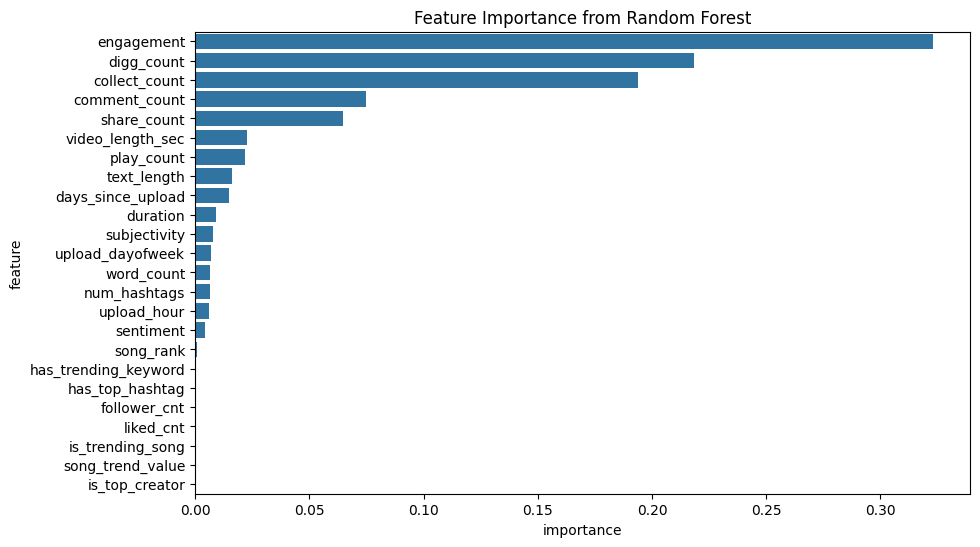


Predicted viral videos saved: predicted_viral_videos.csv

Top 10 Hashtags from Predicted Viral Videos:
#ad: 9
#fyp: 8
#benandjerrys: 3
#AdobePartner: 3
#MadeByGoogle: 2
#inspiration: 2
#teamwater: 2
#neutrogenapartner: 2
#KPopDemonHunters: 2
#cruise: 2


In [39]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# =============================
# Train Model and Predict Viral Videos
# =============================
def train_and_predict(df, feature_cols):
    # Define features and target
    X = df[feature_cols].fillna(df[feature_cols].median())
    y = (df["engagement"] > df["engagement"].median()).astype(int)  # trending label

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Random Forest
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = model.predict(X_test_scaled)
    print("Model Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Feature Importance
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        "feature": feature_cols,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    print("\nFeature Importances:")
    print(feature_importance_df)

    plt.figure(figsize=(10,6))
    sns.barplot(x="importance", y="feature", data=feature_importance_df)
    plt.title("Feature Importance from Random Forest")
    plt.show()

    # Save model + scaler
    with open("rf_model.pkl", "wb") as f:
        pickle.dump(model, f)
    with open("scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)

    # Predict on whole dataset
    X_scaled = scaler.transform(X)
    df["predicted_trending"] = model.predict(X_scaled)

    # Extract predicted viral videos
    viral_videos = df[df["predicted_trending"] == 1].copy()
    viral_videos["prediction_time"] = pd.Timestamp.now()
    viral_videos.to_csv("predicted_viral_videos.csv", index=False)

    print("\nPredicted viral videos saved: predicted_viral_videos.csv")

    return viral_videos, feature_importance_df

# =============================
# Extract Top Hashtags from Viral Videos
# =============================
def extract_top_hashtags(viral_videos, n=10):
    all_hashtags = []
    for tags in viral_videos["all_hashtags"].dropna():
        all_hashtags.extend(tags)

    top_tags = Counter(all_hashtags).most_common(n)
    print(f"\nTop {n} Hashtags from Predicted Viral Videos:")
    for tag, count in top_tags:
        print(f"{tag}: {count}")
    return top_tags

# Run training + viral prediction
viral_videos, feature_importance_df = train_and_predict(df_ready, feature_cols)
top_hashtags = extract_top_hashtags(viral_videos, n=10)


In [44]:
import ast
import numpy as np
import pandas as pd
from datetime import datetime

def build_trend_table_from_predictions(viral_videos, platform="tiktok"):
    trend_records = []

    for _, row in viral_videos.iterrows():
        # Extract hashtags safely
        hashtags = row.get("all_hashtags", [])
        if isinstance(hashtags, str):
            try:
                hashtags = ast.literal_eval(hashtags)
            except Exception:
                hashtags = []

        # For each hashtag in the video
        for tag in hashtags:
            # Random but logical audience split
            gen_z_ratio = np.round(np.random.uniform(0.5, 0.9), 2)
            millennials_ratio = np.round(1 - gen_z_ratio, 2)
            audience_signals = {"gen_z": gen_z_ratio, "millennials": millennials_ratio}

            trend_records.append({
                "trend_id": tag.lower(),
                "token_type": "hashtag",
                "platform": platform,
                "date": row["prediction_time"].strftime("%Y-%m-%d") if "prediction_time" in row else datetime.now().strftime("%Y-%m-%d"),
                "volume": len(hashtags),  # number of hashtags used in this post
                "engagement": row.get("engagement", 0),
                "unique_creators": [row.get("author_username", "unknown")],  # creator name
                "audience_signals": audience_signals,
                "category": categorize_keyword(tag),
                "geo": row.get("country_code", ""),
                "raw_token": tag
            })

    # Convert to DataFrame
    trend_df = pd.DataFrame(trend_records)

    # Aggregate by trend_id
    trend_df = trend_df.groupby("trend_id").agg({
        "token_type": "first",
        "platform": "first",
        "date": "first",
        "volume": "sum",  # total posts/videos for that trend
        "engagement": "sum",
        "unique_creators": lambda x: list(set(sum(x, []))),  # merge creator lists
        "audience_signals": "first",  # placeholder (could average if you want)
        "category": "first",
        "geo": "first",
        "raw_token": "first"
    }).reset_index()

    trend_df.to_csv("trend_table_from_predictions.csv", index=False)
    print(f"\n✅ Trend table built from predictions → trend_table_from_predictions.csv ({len(trend_df)} rows)")
    return trend_df



In [45]:
def build_summary_from_trend_table(trend_df):
    summary_df = trend_df.groupby("trend_id").agg({
        "volume": "sum",
        "engagement": "sum",
        "unique_creators": "sum"
    }).reset_index()

    # Add metrics
    summary_df["current_stage"] = summary_df["volume"].apply(
        lambda v: "emerging" if v < summary_df["volume"].median() else "peak"
    )
    summary_df["growth_rate_7d"] = np.random.uniform(0, 50, len(summary_df))  # replace with real calc if history exists
    summary_df["acceleration"] = np.random.uniform(-10, 10, len(summary_df))
    summary_df["sweet_spot_days_left"] = np.random.randint(1, 10, len(summary_df))
    summary_df["recommended_action"] = summary_df["current_stage"].apply(
        lambda s: "Hop in now" if s == "emerging" else "Leverage while peak"
    )

    summary_df.to_csv("trend_summary_from_predictions.csv", index=False)
    print(f"Trend summary built → trend_summary_from_predictions.csv ({len(summary_df)} trends)")
    return summary_df


In [46]:
# Build trend + summary from ML predicted viral videos
trend_df = build_trend_table_from_predictions(viral_videos, platform="tiktok")
summary_df = build_summary_from_trend_table(trend_df)

print(trend_df.head())
print(summary_df.head())



✅ Trend table built from predictions → trend_table_from_predictions.csv (230 rows)
Trend summary built → trend_summary_from_predictions.csv (230 trends)
                    trend_id token_type platform        date  volume  \
0             #3dwhitestrips    hashtag   tiktok  2025-09-06       4   
1  #abigboldbeautifuljourney    hashtag   tiktok  2025-09-06       3   
2                        #ad    hashtag   tiktok  2025-09-06      29   
3              #adobepartner    hashtag   tiktok  2025-09-06       5   
4     #adobephotoshoppartner    hashtag   tiktok  2025-09-06       3   

   engagement                                    unique_creators  \
0      657411                                        [amberyeet]   
1      753412                          [bigboldbeautifuljourney]   
2     2126767  [christy_ix, joycethedentist, myblissfulhome, ...   
3     1846639  [__kemma, brookemonk_, outsideeric, jeneration...   
4     1650028                                     [rambosphotos]   

    